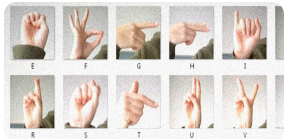

#Sign Language MNIST 데이터 셋

Sign Language MNIST는 수화 인식 문제를 다루는 데이터 셋. 이 데이터 셋은 24가지 클래스로 구성된 28x28 픽셀의 그레이스케일 손 제스처 이미지로 구성되어 있음. 각 클래스는 알파벳 A부터 Z까지 나타내지만, 제스처 동작이 필요한 J와 Z는 제외됨.

제공되는 1D data는 (Height, Width) 형태의 data를 1D로 펼친 것.

- id: int
- label: int

##제공되는 파일 설명
- train.csv: 27,455개의 데이터가 있고, 각 행은 784개의 픽셀값(0~783열)과 label(마지막 열)로 구성 (27,455 x 785)
- test.csv: 7,172개의 데이터가 있고, 각 행은 784개의 픽셀값(0~783열)으로 구성 (7,172 x 784)
- sample_submission.csv: submission 파일 예시

##라벨 정보
데이터 셋의 26가지 클래스는 아래와 같음.
9=J 또는 25=Z에 대한 사례는 없음

0 : A
1 : B
2 : C
3 : D
4 : E
5 : F
6 : G
7 : H
8 : I
9 : (J는 제외)
10 : K
11 ; L
12 : M
13 : N
14 : O
15 : P
16 : Q
17 : R
18 : S
19 : T
20 : U
21 : V
22 : W
23 : X
24 : Y
25 : (Z는 제외)

In [ ]:
import os
import random
from PIL import Image

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torchvision
from torchvision.models import VGG16_Weights
from torchvision.transforms import v2

# 하이퍼파라미터
args = {
    "train_path" : "/kaggle/input/2024-outta-basic-p-1/train.csv",      # train 데이터 경로
    "test_path" : "/kaggle/input/2024-outta-basic-p-1/test.csv",       # test 데이터 경로
    "submit_path" : "/kaggle/input/2024-outta-basic-p-1/sample_submission.csv",     # submit 파일 경로
    "batch_size" : 64,
    "epochs" : 20,
    "lr" : 2e-5,
    "seed_val" : 42         # 절대 수정하지 마세요.
}

# 랜덤시드 고정하기
seed = args["seed_val"]
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available() :
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 디바이스 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 요약 정보를 출력하기 위해 torchsummary 설치
%pip install torchsummary
from torchsummary import summary as summary_

# 모델의 형태를 출력하기 위한 함수
def summary_model(model, input_shape=(3, 32, 32)):
    model = model.to(device)
    summary_(model, input_shape)

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 훈련 및 테스트 데이터 로드
train = pd.read_csv(args['train_path'])
test = pd.read_csv(args['test_path'])

# 훈련 데이터에서 특징(x_train)과 라벨(y_train) 분리
x_train = train.iloc[:, :-1].values  # 첫 번째 열을 제외한 모든 열 (특징)
y_train = train['label'].values      # 'label' 열 (라벨)
x_test = test.values                 # 테스트 데이터

# numpy 배열로 변환 후, torch Tensor로 변환
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)

# 데이터를 (N, H, W, C) 형태로 재구성 (reshape 함수 이용)
x_train = x_train.view(-1, 28, 28, 1)
x_test = x_test.view(-1, 28, 28, 1)

# 데이터를 (N, C, H, W) 형태로 변환 (permute 함수 이용)
x_train = x_train.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)

# 데이터를 (N, 3, 32, 32) 형태로 변환 (resize와 expand 함수 이용)
x_train = torch.nn.functional.interpolate(x_train, size=(32, 32), mode='bilinear', align_corners=False)
x_train = x_train.expand(-1, 3, 32, 32)
x_test = torch.nn.functional.interpolate(x_test, size=(32, 32), mode='bilinear', align_corners=False)
x_test = x_test.expand(-1, 3, 32, 32)

x_train_tensor, x_valid_tensor, y_train_tensor, y_valid_tensor = train_test_split(
    x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train
)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(x_test)

train_dataloader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=args["batch_size"], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# VGG16 모델 로드 및 특징 추출 부분 사용
model = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model = nn.Sequential(*list(model.children())[:-2])

# 모델에 글로벌 평균 풀링 계층 추가
model.global_avg_pool2d = nn.AdaptiveAvgPool2d((1, 1))

# 모델 요약 정보 출력
summary_model(model, input_shape=(3, 32, 32))

# 모델의 앞부분 파라미터 고정 (동결)
for para in model[:-8].parameters():
    para.requires_grad = False

# 파라미터 동결 후 모델 요약 정보 출력
summary_model(model, input_shape=(3, 32, 32))

# 새로운 분류기 정의
classifier = nn.Sequential(
    nn.Flatten(),                 # 3D 출력을 1D로 평탄화
    nn.Linear(512, 4096),         # 첫 번째 Fully Connected Layer
    nn.ReLU(True),                # ReLU 활성화 함수
    nn.Dropout(),                 # 드롭아웃 계층
    nn.Linear(4096, 4096),        # 두 번째 Fully Connected Layer
    nn.ReLU(True),                # ReLU 활성화 함수
    nn.Dropout(),                 # 드롭아웃 계층
    nn.Linear(4096, 25)           # 마지막 Fully Connected Layer: 25개의 클래스로 분류
)

# 모델에 새로운 분류기 추가
model.add_module("classifier", classifier)

# 모델을 장치로 이동
model = model.to(device)

# 최종 모델 요약 정보 출력
summary_model(model, input_shape=(3, 32, 32))

# 옵티마이저 및 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
# 훈련 함수 정의
def train(train_loader, valid_loader, model, device, args):
    model.train()

    for epoch in range(args['epochs']):
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)

        print(f'Epoch {epoch+1}/{args["epochs"]}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation step
        model.eval()
        val_loss = 0.0
        correct_predictions_val = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions_val += torch.sum(preds == labels)

        val_loss /= len(valid_loader.dataset)
        val_acc = correct_predictions_val.double() / len(valid_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        model.train()  # back to training mode

if __name__ == "__main__":
    train(train_dataloader, valid_dataloader, model, device, args)

100%|██████████| 344/344 [00:13<00:00, 25.11it/s]


Epoch 1/20, Loss: 1.2621, Accuracy: 0.6275
Validation Loss: 0.0247, Validation Accuracy: 0.9960


100%|██████████| 344/344 [00:13<00:00, 25.90it/s]


Epoch 2/20, Loss: 0.0250, Accuracy: 0.9926
Validation Loss: 0.0008, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 25.66it/s]


Epoch 3/20, Loss: 0.0097, Accuracy: 0.9974
Validation Loss: 0.0045, Validation Accuracy: 0.9984


100%|██████████| 344/344 [00:13<00:00, 25.51it/s]


Epoch 4/20, Loss: 0.0069, Accuracy: 0.9980
Validation Loss: 0.0035, Validation Accuracy: 0.9984


100%|██████████| 344/344 [00:13<00:00, 25.24it/s]


Epoch 5/20, Loss: 0.0035, Accuracy: 0.9991
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 25.03it/s]


Epoch 6/20, Loss: 0.0079, Accuracy: 0.9983
Validation Loss: 0.0988, Validation Accuracy: 0.9765


100%|██████████| 344/344 [00:13<00:00, 24.72it/s]


Epoch 7/20, Loss: 0.0075, Accuracy: 0.9978
Validation Loss: 0.0010, Validation Accuracy: 0.9998


100%|██████████| 344/344 [00:13<00:00, 24.70it/s]


Epoch 8/20, Loss: 0.0002, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.68it/s]


Epoch 9/20, Loss: 0.0001, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:14<00:00, 24.54it/s]


Epoch 10/20, Loss: 0.0038, Accuracy: 0.9992
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:14<00:00, 24.32it/s]


Epoch 11/20, Loss: 0.0001, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.61it/s]


Epoch 12/20, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.70it/s]


Epoch 13/20, Loss: 0.0214, Accuracy: 0.9945
Validation Loss: 0.0011, Validation Accuracy: 0.9998


100%|██████████| 344/344 [00:13<00:00, 24.68it/s]


Epoch 14/20, Loss: 0.0019, Accuracy: 0.9995
Validation Loss: 0.0001, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.63it/s]


Epoch 15/20, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.58it/s]


Epoch 16/20, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.64it/s]


Epoch 17/20, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.59it/s]


Epoch 18/20, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.66it/s]


Epoch 19/20, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


100%|██████████| 344/344 [00:13<00:00, 24.64it/s]


Epoch 20/20, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


In [ ]:
def test(test_loader, model, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in tqdm(test_loader):
            inputs = inputs[0].to(device)  # inputs[0] 사용, 이유는 test_loader가 tuple로 데이터를 가져오기 때문
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.append(preds.item())

    return predictions


if __name__ == "__main__":
    # 예측값을 얻기 위해 test 함수 호출
    preds = test(test_dataloader, model, device)

100%|██████████| 7172/7172 [00:19<00:00, 374.19it/s]


In [ ]:
submit = pd.read_csv(args["submit_path"])
submit["label"] = preds

In [ ]:
submit.to_csv("submission_p1.csv", index = False)

In [ ]:
submit

,id,label
0,0,6
1,1,5
2,2,10
3,3,0
4,4,3
...,...,...
7167,7167,1
7168,7168,12
7169,7169,2
7170,7170,4
